In [98]:
from collections import Counter
import ast
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('_mpl-gallery')
%matplotlib inline
pd.set_option('display.max_columns', None)

In [74]:
data_path = "./data/listings/"
data = pd.DataFrame()
for file_name in os.listdir(data_path):
    data = pd.concat([data, pd.read_csv(f"{data_path}{file_name}", sep=",")], ignore_index=True)

In [75]:
data.sort_values(by="last_scraped", ascending=False, inplace=True)
data.drop_duplicates(subset=["id"], keep="first", inplace=True)

In [76]:
# data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74859 entries, 42845 to 37469
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            74859 non-null  int64  
 1   listing_url                                   74859 non-null  object 
 2   scrape_id                                     74859 non-null  int64  
 3   last_scraped                                  74859 non-null  object 
 4   source                                        74859 non-null  object 
 5   name                                          74850 non-null  object 
 6   description                                   73614 non-null  object 
 7   neighborhood_overview                         45659 non-null  object 
 8   picture_url                                   74859 non-null  object 
 9   host_id                                       74859 non-n

In [77]:
data["amenities"] = [ast.literal_eval(amenities) for amenities in data["amenities"]]

In [78]:
def normalize_amenity(amenity: str) -> str:
    amenity = amenity.lower()
    amenity = amenity.replace("-", " ")
    amenity = re.sub(r"[^\w\s]", " ", amenity)
    amenity = re.sub(r"[\s]{2,}", " ", amenity)
    amenity = amenity.strip()
    return amenity

In [79]:
amenities = [normalize_amenity(amenity) for amenities in data["amenities"] for amenity in amenities]
amenities = Counter(amenities)

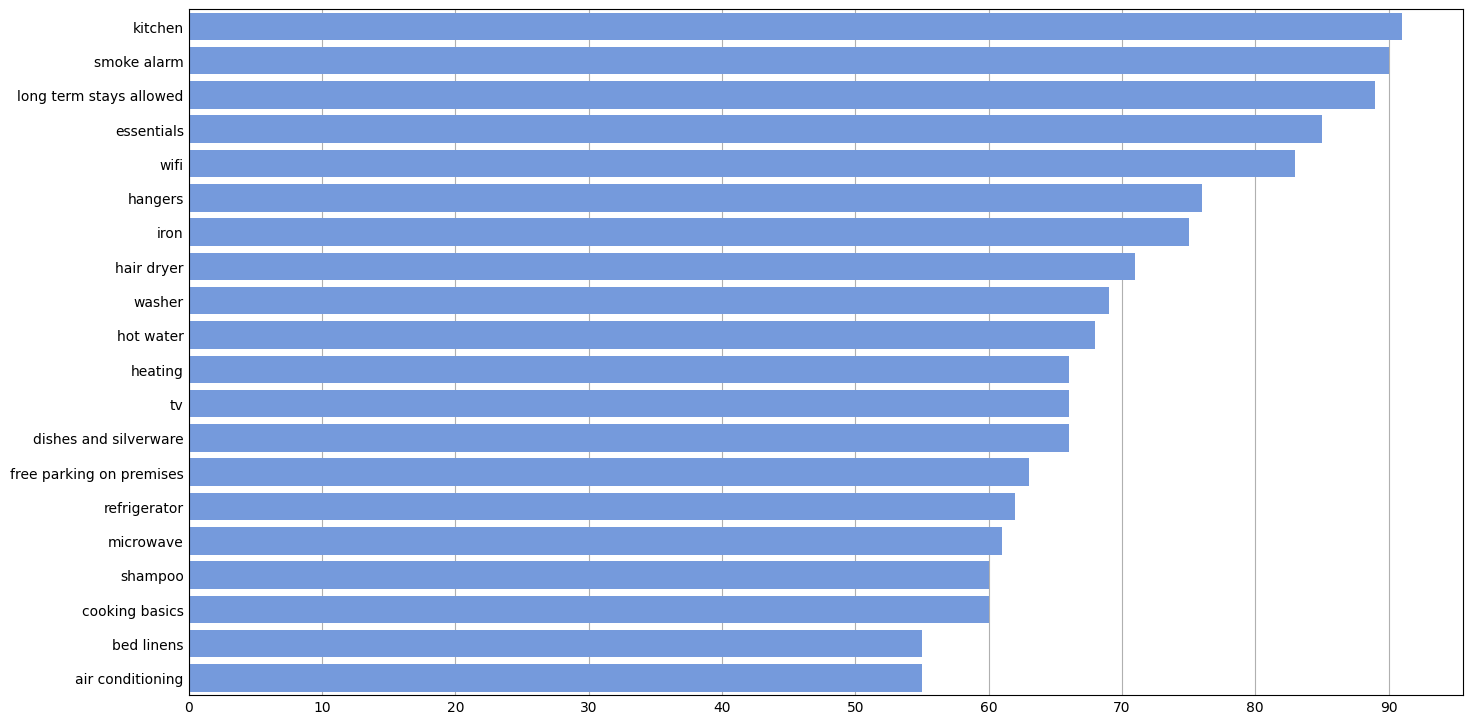

In [175]:
top20_amenities = dict(sorted(amenities.items(), key=lambda x:x[1], reverse=True)[:20])
top20_values_in_percent = [round(value / len(data) * 100) for value in top20_amenities.values()]

plt.figure(figsize=(13, 7))
plt.xticks(range(0,100,10))
sns.barplot(x=top20_values_in_percent, y=list(top20_amenities.keys()), color = "cornflowerblue");

In [80]:
# remove unpopular (not standardized) amenity values
MIN_AMENITY_COUNT = 200

origin_amenity_keys = len(amenities.keys())
origin_amenity_values_sum = sum(amenities.values())

amenities = {amenity: amenity_count for (amenity, amenity_count) in amenities.items() if amenity_count >= MIN_AMENITY_COUNT}

print(f"Removed {round(abs(len(amenities.keys()) / origin_amenity_keys - 1) * 100, 1)}% amenity keys "
      f"but only {round(abs(sum(amenities.values()) / origin_amenity_values_sum - 1) * 100, 1)}% of the set amenity values in total.")

Removed 97.4% amenity keys but only 1.5% of the set amenity values in total.


In [84]:
new_amenity_data = pd.concat([pd.Series(name=f"amenity_{amenity}",
                              data=[amenity in accomodation_amenities for accomodation_amenities in data["amenities"]]) 
                              for amenity in amenities.keys()], axis=1)
data = pd.concat([data, new_amenity_data], axis=1)